# Important: Modify the pynvrtc package as described in the following:
https://github.com/loicland/superpoint_graph/issues/43#issuecomment-406928322

# Imports

In [31]:
from torchqrnn import QRNN, QRNNLayer

In [32]:
import numpy as np

from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU, Conv1d
import torch.nn.functional as F

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

DATA_DIRECTORY = "data/"

In [33]:
# torch.backends.cudnn.enabled=False

In [34]:
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(use_cuda)

True


In [35]:
id_seqs = {str(i):[] for i in range(6)}
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    for line in fIn :
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

In [36]:
print(len(id_seqs['1'][0]))
print(len(id_seqs['3']))

1631
2874


In [37]:
import random

In [38]:
seq_0 = random.sample(id_seqs['0'],200)
seq_3 = random.sample(id_seqs['3'],200)

In [39]:
with open('train_mini_0and3.txt','w') as fOut : 
    for seq in seq_0 : 
        fOut.write(seq + "," + "0\n")
    for seq in seq_3 : 
        fOut.write(seq + "," + "3\n") 

## taking only 500 first nucleotids

In [40]:
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'train_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [41]:
with open(DATA_DIRECTORY+'test_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'test_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [42]:
with open(DATA_DIRECTORY+'val_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'val_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

# Torchtext dataloader 

In [43]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

#train_set, validation_set, test_set = data.TabularDataset.splits(path='',
#                                                                 train='train_mini_0and3.txt',
#                                                                 validation='train_mini_0and3.txt',
#                                                                 test='train_mini_0and3.txt', 
#                                                                 format = 'csv',
#                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train=DATA_DIRECTORY+'train_filtered_reduced.txt',
                                                                 validation=DATA_DIRECTORY+'val_filtered_reduced.txt',
                                                                 test=DATA_DIRECTORY+'test_filtered_reduced.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

In [14]:
#L = [len(train_set[i].sequence) for i in range(len(train_set))]
#plt.hist(L)


In [15]:
#print('train_set.fields:', list(train_set.fields.keys()))
#print('validation_set.fields:', list(validation_set.fields.keys()))
#print('test_set.fields:', list(test_set.fields.keys()))
#print()
#print('size of training set', len(train_set))
#print('size of validation set', len(validation_set))
#print()
#print('content of first training sample:')
#print(vars(train_set[0]))

In [44]:
# build the vocabularies
SEQ.build_vocab(train_set, min_freq=2) #NO unknows 
LABEL.build_vocab(train_set, )

In [45]:
SEQ.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'N': 0, '<pad>': 1, 'G': 2, 'C': 3, 'A': 4, 'T': 5})

In [46]:
print('Text fields:')
print(' size of vocabulary:', len(SEQ.vocab))
#print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ.vocab.freqs['N'])
#print(" list of vocabulary (int-to-str):", SEQ.vocab.itos)
#print(" list of vocabulary (str-to-int):", dict(SEQ.vocab.stoi))
#print(SEQ.vocab.freqs)
#print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
#print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
#print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))
#print(LABEL.vocab.freqs)

Text fields:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 57


In [47]:
#weight = [i/sum(dic.values()) for i in dic.values()]
#weight_square = [i**2 for i in weight]
#weight_square = torch.FloatTensor(weight_square).cuda()
#weight_square = 1 - weight_square/sum(weight_square)


#final_weights = torch.FloatTensor([weight_square[int(i)] for i in LABEL.vocab.itos]).cuda()
#print(final_weights)

In [49]:
BATCH_SIZE = 2

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                 sort = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


In [117]:
# size of embeddings
EMBEDDING_DIM = 8
NUM_EMBEDDING = len(SEQ.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
HIDDEN_DIM = 128
NUM_LAYERS_LSTM = 1
SEQ_LEN = len(train_set[0].sequence)
print(SEQ_LEN)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #learn a new embedding
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)

        # use pretrained embeddings
        
        #self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
        #                    out_channels= CONV_CHANNELS,
        #                    padding=0,
        #                    kernel_size=1,
        #                    stride=1)
        
        
        
        
        #self.lstm = LSTM(input_size=EMBEDDING_DIM,
        #                 hidden_size=HIDDEN_DIM,
        #                 num_layers=NUM_LAYERS_LSTM,
        #                 bidirectional=False)
        
        self.qrnn = QRNN(EMBEDDING_DIM, HIDDEN_DIM, num_layers=2)
        self.qrnn.cuda()
        
        # link hidden to tag 
        self.linear = Linear(in_features=HIDDEN_DIM,
                            out_features=NUM_CLASSES)
        
        
        #init lstm hidden units 
        self.hidden = self.init_hidden(BATCH_SIZE)
        
    def forward(self, x):
        sequences = x[0]
        lengths = x[1]
#         out = {}
        batch_size = sequences.size()[1]
        # get embeddings
        x = self.embeddings(sequences)
        #x = embeds.permute([1,2,0])
        #c1 = F.relu(self.conv1(x))
        #c2 = F.relu(self.conv2(x))
        #c3 = F.relu(self.conv3(x))
        #x = torch.cat((c1,c2,c3), 1)
        #x = x.permute([2,0,1])
        
        #embeds = nn.utils.rnn.pack_padded_sequence(embeds,lengths/3, batch_first=False)
        # rnn returns output and last hidden state
        
        _, x = self.qrnn(x)
        #lstm_out, self.hidden = self.lstm(embeds)
        #unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=False)
        x = F.relu(x[-1].type(torch.float))
        #last_output = self.dropout(last_output)
        
        freqs = F.softmax(self.linear(x))
        return freqs
    
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, HIDDEN_DIM),
                torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, HIDDEN_DIM))

net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

500
using cuda
Net(
  (embeddings): Embedding(6, 8)
  (qrnn): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=8, out_features=384, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=128, out_features=384, bias=True)
      )
    )
  )
  (linear): Linear(in_features=128, out_features=6, bias=True)
)


In [118]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

{'embeddings.weight': True,
 'qrnn.layers.0.linear.weight': True,
 'qrnn.layers.0.linear.bias': True,
 'qrnn.layers.1.linear.weight': True,
 'qrnn.layers.1.linear.bias': True,
 'linear.weight': True,
 'linear.bias': True}

In [119]:
criterion = nn.CrossEntropyLoss() #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [120]:
torch.cuda.memory_allocated() 

41433600

In [ ]:
t0 = time.time()

num_epoch = 500
iter_by_epoch = int(len(train_set)/BATCH_SIZE)
eval_every = 100

reduced_train_lost = []
reduced_train_accuracy = []

reduced_val_lost = []
reduced_val_accuracy = []

train_loss, train_accs = [], []
val_loss, val_accs = [], []

epoch_index = []
i = 0


for epoch in range(num_epoch):
    
    train_loss, train_accs = [], []
    val_loss, val_accs = [], []
    
    net.train()
    # Training
    for i, batch in enumerate(train_iter):
            
        optimizer.zero_grad()

        output = net(batch.sequence)
        batch_loss = criterion(output, batch.label)

        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output, batch.label)))


        if i % eval_every == 0:     
            net.eval()
            val_losses_running, val_accs_running, val_lengths = 0, 0, 0
            
            for val_batch in validation_iter:
                output = net(val_batch.sequence)
                val_losses_running += criterion(output, val_batch.label)*val_batch.batch_size
                val_accs_running += accuracy(output, val_batch.label) *val_batch.batch_size
                val_lengths += val_batch.batch_size

            # divide by the total accumulated batch sizes
            val_losses_running /= val_lengths
            val_accs_running /= val_lengths
            val_loss.append(get_numpy(val_losses_running))
            val_accs.append(get_numpy(val_accs_running))
            net.train()
        
        batch_loss.backward()     
        optimizer.step()
        
        i += 1
    
    reduced_train_lost.append(np.mean(train_loss))
    reduced_train_accuracy.append(np.mean(train_accs))
    
    reduced_val_lost.append(np.mean(val_loss))
    reduced_val_accuracy.append(np.mean(val_accs))
    
    epoch_index.append(epoch)
    
    print(f'Epoch {epoch}\tTrain {np.mean(train_loss):.3f}\tVal {np.mean(val_loss):.3f}')
    
# 500, 20, 100/

t1 = time.time()

Epoch 0	Train 1.652	Val 1.669
Epoch 1	Train 1.650	Val 1.671
Epoch 2	Train 1.645	Val 1.668
Epoch 3	Train 1.640	Val 1.667
Epoch 4	Train 1.634	Val 1.667
Epoch 5	Train 1.635	Val 1.666
Epoch 6	Train 1.632	Val 1.665
Epoch 7	Train 1.633	Val 1.665
Epoch 8	Train 1.633	Val 1.663
Epoch 9	Train 1.632	Val 1.662
Epoch 10	Train 1.633	Val 1.663
Epoch 11	Train 1.629	Val 1.663
Epoch 12	Train 1.627	Val 1.664
Epoch 13	Train 1.623	Val 1.662
Epoch 14	Train 1.624	Val 1.663
Epoch 15	Train 1.621	Val 1.664
Epoch 16	Train 1.623	Val 1.665
Epoch 17	Train 1.619	Val 1.665
Epoch 18	Train 1.619	Val 1.665
Epoch 19	Train 1.617	Val 1.665
Epoch 20	Train 1.616	Val 1.665
Epoch 21	Train 1.614	Val 1.665
Epoch 22	Train 1.617	Val 1.665
Epoch 23	Train 1.616	Val 1.662
Epoch 24	Train 1.618	Val 1.663
Epoch 25	Train 1.623	Val 1.664
Epoch 26	Train 1.617	Val 1.662
Epoch 27	Train 1.613	Val 1.660
Epoch 28	Train 1.614	Val 1.660
Epoch 29	Train 1.611	Val 1.659
Epoch 30	Train 1.612	Val 1.662
Epoch 31	Train 1.615	Val 1.662
Epoch 32	Train 1.6

In [ ]:
delta = t1-t0

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epoch_index,reduced_train_lost,label='train_loss')
plt.plot(epoch_inde
         x,reduced_val_lost, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_index, reduced_train_accuracy, label='train_accs')
plt.plot(epoch_index, reduced_val_accuracy, label='valid_accs')
plt.legend()
plt.show()
plt.savefig(fig, format="svg")

In [ ]:

valid_iter = [i - 112 for i in valid_iter]

In [ ]:
train_loss_red = []
little = []
compt = 1
for i in train_loss : 
    little.append(i)
    if compt%100 == 0:
        print(compt)
        train_loss_red.append(np.mean(little))
        little = []
    compt+=1

In [ ]:
np.mean(train_accs[:-100])

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_red, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.legend()
plt.show()


In [102]:
torch.max(output,1)[1]

tensor([1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2],
       device='cuda:0')

In [356]:
net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []
for val_batch in train_iter:
    output = net(val_batch.sequence)
    predictions += [int(i) for i in torch.max(output,1)[1]]
    real_values += [int(i) for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    print(accuracy(output, val_batch.label) *val_batch.batch_size, val_batch.batch_size)
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

print("[%i]"%get_numpy(val_accs), val_lengths, val_accs)
# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
print("[%i]"%get_numpy(val_accs))
net.train()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(15., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(17., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
[387] 400 tensor(387., device='cuda:0')
[0]


Net(
  (embeddings): Embedding(6, 100)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(3,))
  (lstm): LSTM(100, 111)
  (hidden2tag): Linear(in_features=111, out_features=3, bias=False)
)

In [357]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [358]:
output

tensor([[8.3939e-07, 7.8227e-04, 9.9922e-01],
        [1.1353e-06, 7.3812e-05, 9.9993e-01],
        [8.5646e-06, 1.8252e-03, 9.9817e-01],
        [6.4346e-06, 3.1196e-03, 9.9687e-01],
        [2.4455e-04, 4.5467e-03, 9.9521e-01],
        [4.9675e-06, 8.7108e-04, 9.9912e-01],
        [1.5768e-05, 1.5943e-03, 9.9839e-01],
        [1.4948e-04, 2.4624e-03, 9.9739e-01],
        [1.3874e-05, 2.1734e-03, 9.9781e-01],
        [2.4438e-06, 5.0490e-05, 9.9995e-01],
        [3.6360e-06, 8.7438e-05, 9.9991e-01],
        [1.6291e-05, 2.7198e-03, 9.9726e-01],
        [1.5844e-05, 4.1070e-04, 9.9957e-01],
        [6.0377e-06, 1.4313e-03, 9.9856e-01],
        [7.8869e-06, 1.8403e-03, 9.9815e-01],
        [1.8819e-05, 1.8621e-03, 9.9812e-01],
        [1.2744e-05, 1.2774e-04, 9.9986e-01],
        [4.6169e-06, 4.3788e-03, 9.9562e-01],
        [1.7736e-05, 1.7656e-03, 9.9822e-01],
        [1.4403e-05, 8.0118e-05, 9.9991e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [359]:
from sklearn.metrics import confusion_matrix
import itertools

In [360]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



Normalized confusion matrix
[[ nan  nan  nan]
 [0.01 0.97 0.02]
 [0.01 0.02 0.96]]


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


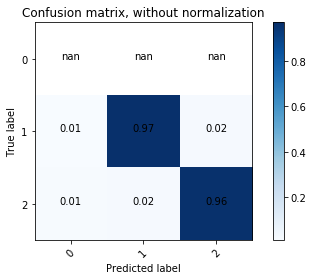

In [361]:
cnf_matrix = confusion_matrix(real_values, predictions)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classes = [str(i) for i in range(NUM_CLASSES)]
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, without normalization', normalize=True)


plt.show()


In [1]:
import subprocess
def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [39]:
get_gpu_memory_map()

{0: 6647}

In [80]:
times

[[1544748126.33426, 1544762510.6079597]]

In [81]:
times[0][1]-times[0][0]

14384.273699760437

In [82]:
k

2

In [83]:
total_train_acc

[[0.37578702,
  0.3783192,
  0.3818779,
  0.38201478,
  0.38550505,
  0.38988504,
  0.39255407,
  0.3933753,
  0.39474404,
  0.39693403,
  0.39782372,
  0.39713934,
  0.39590746,
  0.39590746,
  0.3963181,
  0.39679715,
  0.40049276,
  0.40213522,
  0.4000137,
  0.40069807,
  0.39994526,
  0.40145087,
  0.4011771,
  0.39980838,
  0.39789215,
  0.39871338,
  0.3994662,
  0.3993293,
  0.39994526,
  0.3998768,
  0.40090337,
  0.40192991,
  0.4024774,
  0.40124556,
  0.4009718,
  0.40213522,
  0.40192991,
  0.40275118,
  0.40275118,
  0.4018615,
  0.402409,
  0.4009718,
  0.40254584,
  0.40275118,
  0.40124556,
  0.40179303,
  0.40329865,
  0.40384614,
  0.4018615,
  0.4029565,
  0.40165618,
  0.40364084,
  0.4046674,
  0.40569395,
  0.40658364,
  0.40630987,
  0.40658364,
  0.40418833,
  0.40555707,
  0.40548864,
  0.40507802,
  0.40192991,
  0.4022721,
  0.40268272,
  0.40158772,
  0.40165618,
  0.4028196,
  0.40583083,
  0.40569395,
  0.4033671,
  0.40329865,
  0.40192991,
  0.40138242,

In [84]:
total_val_acc

[[0.36340585,
  0.36293897,
  0.3634642,
  0.36418396,
  0.36482593,
  0.36550683,
  0.36614877,
  0.36769208,
  0.36741325,
  0.3669464,
  0.36734837,
  0.36718628,
  0.36620715,
  0.3667583,
  0.36644703,
  0.36312053,
  0.3619663,
  0.36278334,
  0.36162266,
  0.36195982,
  0.36157078,
  0.36190146,
  0.36127898,
  0.36157724,
  0.3614735,
  0.36199874,
  0.36178476,
  0.3625434,
  0.36158374,
  0.3623035,
  0.3618885,
  0.36120117,
  0.36275744,
  0.3623748,
  0.36251745,
  0.36203116,
  0.3629844,
  0.36260828,
  0.36231,
  0.3622257,
  0.3628871,
  0.36282876,
  0.36166155,
  0.36226463,
  0.3631011,
  0.3630622,
  0.36136976,
  0.36256933,
  0.36101308,
  0.36223868,
  0.36149293,
  0.36190146,
  0.36169398,
  0.36216736,
  0.36273146,
  0.3625499,
  0.36271852,
  0.36505938,
  0.36133087,
  0.3623878,
  0.3619728,
  0.3665054,
  0.36409968,
  0.3643331,
  0.36531228,
  0.366674,
  0.36124006,
  0.36245915,
  0.36338642,
  0.36578566,
  0.366071,
  0.36672586,
  0.36698523,
  0.

In [124]:
time.time()

1544781035.925805